In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from datetime import datetime 
import cv2
from PIL import Image
from keras import backend, optimizers

2023-03-07 17:28:04.873685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 17:28:05.062221: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-07 17:28:05.722680: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/cudnn-8.4/8.4/lib64:/cm/local/apps/cuda/libs/current/lib64:/cm/shared/apps/cuda11.2/toolkit/11.2.0/targets/x86_64-linux/lib:/cm/local/apps/gcc/7.2.0/lib:/cm/local/apps/gcc/7.2.0/lib64:/hom

In [2]:
path = 'PH2Dataset/PH2 Dataset images/'
im_folders = os.listdir(path)
im_folders

['IMD002',
 'IMD003',
 'IMD004',
 'IMD006',
 'IMD008',
 'IMD009',
 'IMD010',
 'IMD013',
 'IMD014',
 'IMD015',
 'IMD016',
 'IMD017',
 'IMD018',
 'IMD019',
 'IMD020',
 'IMD021',
 'IMD022',
 'IMD023',
 'IMD024',
 'IMD025',
 'IMD027',
 'IMD030',
 'IMD031',
 'IMD032',
 'IMD033',
 'IMD035',
 'IMD036',
 'IMD037',
 'IMD038',
 'IMD039',
 'IMD040',
 'IMD041',
 'IMD042',
 'IMD043',
 'IMD044',
 'IMD045',
 'IMD047',
 'IMD048',
 'IMD049',
 'IMD050',
 'IMD057',
 'IMD058',
 'IMD061',
 'IMD063',
 'IMD064',
 'IMD065',
 'IMD075',
 'IMD076',
 'IMD078',
 'IMD080',
 'IMD085',
 'IMD088',
 'IMD090',
 'IMD091',
 'IMD092',
 'IMD101',
 'IMD103',
 'IMD105',
 'IMD107',
 'IMD108',
 'IMD112',
 'IMD118',
 'IMD120',
 'IMD125',
 'IMD126',
 'IMD132',
 'IMD133',
 'IMD134',
 'IMD135',
 'IMD137',
 'IMD138',
 'IMD139',
 'IMD140',
 'IMD142',
 'IMD143',
 'IMD144',
 'IMD146',
 'IMD147',
 'IMD149',
 'IMD150',
 'IMD152',
 'IMD153',
 'IMD154',
 'IMD155',
 'IMD156',
 'IMD157',
 'IMD159',
 'IMD160',
 'IMD161',
 'IMD162',
 'IMD164',

In [3]:
images = []
SIZE = 256
for ind,i in enumerate(im_folders):
    tmp_path = path+i+'/'+i+'_Dermoscopic_Image/'+i+'.bmp'
    im = cv2.imread(tmp_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (256, 256), interpolation= cv2.INTER_LINEAR)
    images.append(np.array(im))

In [4]:
masks = []
SIZE = 256
for ind,i in enumerate(im_folders):
    tmp_path = path+i+'/'+i+'_lesion/'+i+'_lesion.bmp'
    im = cv2.imread(tmp_path)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    im = cv2.resize(im, (256, 256), interpolation= cv2.INTER_LINEAR)
    masks.append(np.array(im))

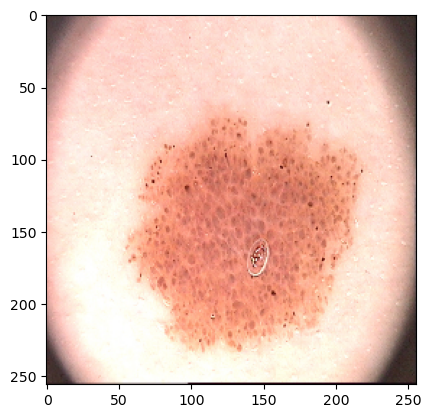

In [5]:
plt.imshow(images[100])

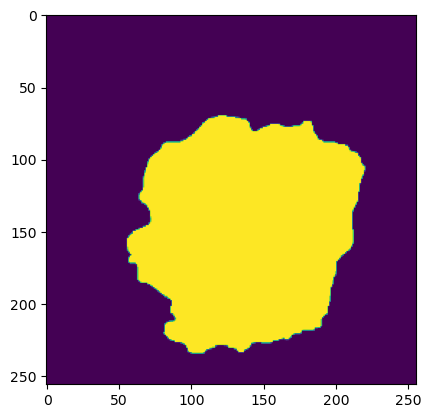

In [6]:
plt.imshow(masks[100])

In [7]:
images = np.array(images)/255.
masks = np.expand_dims((np.array(masks)),3) /255.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = 0.10, random_state = 0)

In [9]:
X_train.shape

(180, 256, 256, 3)

In [10]:
y_train.shape

(180, 256, 256, 1)

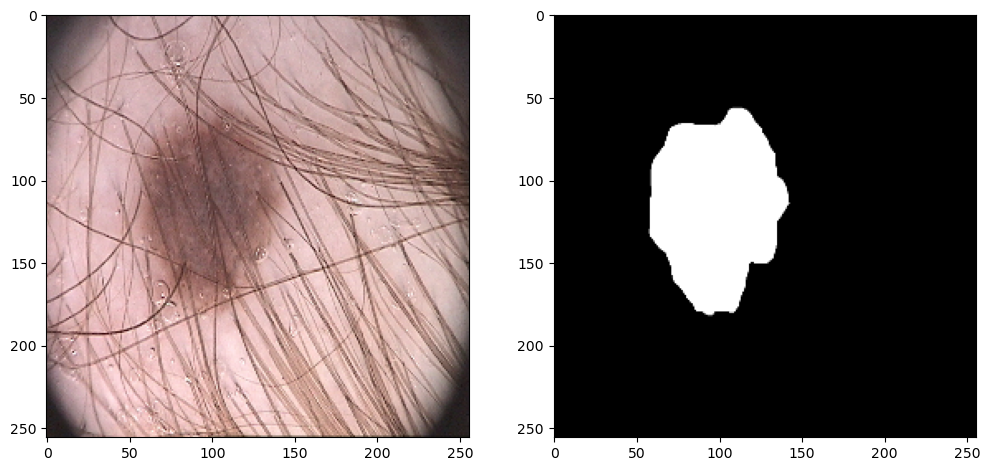

In [11]:
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)))
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [12]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8

#FOCAL LOSS AND DICE METRIC
#Focal loss helps focus more on tough to segment classes.
from focal_loss import BinaryFocalLoss

In [13]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
from keras.models import Model

In [14]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [15]:
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)


def res_conv_block_2(x, filter_size, size, dropout, batch_norm=False):


    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def res_conv_block_3(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)    #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):

    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

In [16]:
def Attention_ResSegNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):

    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_64 = res_conv_block_2(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 2
    conv_128 = res_conv_block_2(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_128 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 3
    conv_256 = res_conv_block_3(pool_128, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_256 = layers.MaxPooling2D(pool_size=(2,2))(conv_256)
    # DownRes 4
    conv_512_1 = res_conv_block_3(pool_256, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_512_1 = layers.MaxPooling2D(pool_size=(2,2))(conv_512_1)
    # DownRes 5
    conv_512_2 = res_conv_block_3(pool_512_1, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_512_2 = layers.MaxPooling2D(pool_size=(2,2))(conv_512_2)
    # DownRes 6, convolution only
    bridge = res_conv_block_2(pool_512_2, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 7, attention gated concatenation + upsampling + double residual convolution
    gating_512_2 = gating_signal(bridge, 8*FILTER_NUM, batch_norm)
    att_512_2 = attention_block(conv_512_2, gating_512_2, 8*FILTER_NUM)
    up_512_2 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(bridge)
    up_512_2 = layers.concatenate([up_512_2, att_512_2], axis=axis)
    up_conv_512_2 = res_conv_block_3(up_512_2, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_512_1 = gating_signal(up_conv_512_2, 8*FILTER_NUM, batch_norm)
    att_512_1 = attention_block(conv_512_1, gating_512_1, 8*FILTER_NUM)
    up_512_1 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_512_2)
    up_512_1 = layers.concatenate([up_512_1, att_512_1], axis=axis)
    up_conv_512_1 = res_conv_block_3(up_512_1, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_256 = gating_signal(up_conv_512_1, 4*FILTER_NUM, batch_norm)
    att_256 = attention_block(conv_256, gating_256, 4*FILTER_NUM)
    up_256 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_512_1)
    up_256 = layers.concatenate([up_256, att_256], axis=axis)
    up_conv_256 = res_conv_block_3(up_256, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 10
    gating_128 = gating_signal(up_conv_256, 2*FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, 2*FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_256)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block_2(up_128, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_64 = gating_signal(up_conv_128, FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_128)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block_2(up_64, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_64)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model, inputs, att_512_2, att_512_1, att_256, att_128, att_64

In [17]:
att_res_SegNet_model, input_inter, att_512_2, att_512_1, att_256, att_128, att_64 = Attention_ResSegNet(input_shape)

att_res_SegNet_model.compile(optimizer=Adam(lr = 1e-2), loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy', jacard_coef])

print(att_res_SegNet_model.summary())


start3 = datetime.now() 
att_res_SegNet_history = att_res_SegNet_model.fit(X_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ), 
                    shuffle=False,
                    epochs=150)
stop3 = datetime.now()

#Execution time of the model 
execution_time_AttResSegNet = stop3-start3
print("Attention ResSegNet execution time is: ", execution_time_AttResSegNet)

att_res_SegNet_model.save('ph2_AttResSegNet_50epochs_B_focal.hdf5')


2023-03-07 17:28:14.902303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 17:28:15.581760: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14625 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                  

 batch_normalization_9 (BatchNo  (None, 64, 64, 256)  1024       ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 64, 64, 256)  1024       ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 add_2 (Add)                    (None, 64, 64, 256)  0           ['batch_normalization_9[0][0]',  
                                                                  'batch_normalization_8[0][0]']  
                                                                                                  
 activation_6 (Activation)      (None, 64, 64, 256)  0           ['add_2[0][0]']                  
          

                                                                                                  
 conv2d_19 (Conv2D)             (None, 8, 8, 1024)   9438208     ['activation_13[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 8, 8, 1024)  4096        ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_19 (BatchN  (None, 8, 8, 1024)  4096        ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_5 (Add)                    (None, 8, 8, 1024)   0           ['batch_normalization_20[0][0]', 
          

                                                                                                  
 conv2d_30 (Conv2D)             (None, 16, 16, 512)  262656      ['activation_20[0][0]']          
                                                                                                  
 batch_normalization_27 (BatchN  (None, 16, 16, 512)  2048       ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_21 (Activation)     (None, 16, 16, 512)  0           ['batch_normalization_27[0][0]'] 
                                                                                                  
 conv2d_32 (Conv2D)             (None, 16, 16, 512)  262656      ['activation_21[0][0]']          
                                                                                                  
 conv2d_tr

                                                                                                  
 add_10 (Add)                   (None, 32, 32, 256)  0           ['conv2d_transpose_2[0][0]',     
                                                                  'conv2d_40[0][0]']              
                                                                                                  
 activation_28 (Activation)     (None, 32, 32, 256)  0           ['add_10[0][0]']                 


/home/ok_sikha/anaconda3/envs/tf_gpu_segnet/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 conv2d_42 (Conv2D)             (None, 32, 32, 1)    257         ['activation_28[0][0]']          
                                                                                                  
 activation_29 (Activation)     (None, 32, 32, 1)    0           ['conv2d_42[0][0]']              
                                                                                                  
 up_sampling2d_4 (UpSampling2D)  (None, 64, 64, 1)   0           ['activation_29[0][0]']          
                                                                                                  
 lambda_2 (Lambda)              (None, 64, 64, 256)  0           ['up_sampling2d_4[0][0]']        
                                                                                                  
 multiply_2 (Multiply)          (None, 64, 64, 256)  0           ['lambda_2[0][0]',               
          

                                8)                                                                
                                                                                                  
 up_sampling2d_7 (UpSampling2D)  (None, 128, 128, 25  0          ['activation_32[0][0]']          
                                6)                                                                
                                                                                                  
 batch_normalization_40 (BatchN  (None, 128, 128, 12  512        ['conv2d_52[0][0]']              
 ormalization)                  8)                                                                
                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 38  0           ['up_sampling2d_7[0][0]',        
                                4)                                'batch_normalization_40[0][0]'] 
          

 concatenate_4 (Concatenate)    (None, 256, 256, 19  0           ['up_sampling2d_9[0][0]',        
                                2)                                'batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 256, 256, 64  110656      ['concatenate_4[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_46 (BatchN  (None, 256, 256, 64  256        ['conv2d_61[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_41 (Activation)     (None, 256, 256, 64  0           ['batch_normalization_46[0][0]'] 
          

2023-03-07 17:28:26.952339: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


23/23 [==============================] - 27s 532ms/step - loss: 0.1056 - accuracy: 0.8480 - jacard_coef: 0.3777 - val_loss: 11.8976 - val_accuracy: 0.2592 - val_jacard_coef: 0.2348
Epoch 2/150
23/23 [==============================] - 7s 298ms/step - loss: 0.0721 - accuracy: 0.8967 - jacard_coef: 0.4092 - val_loss: 11.8976 - val_accuracy: 0.2592 - val_jacard_coef: 0.2348
Epoch 3/150
23/23 [==============================] - 7s 296ms/step - loss: 0.0625 - accuracy: 0.9113 - jacard_coef: 0.4283 - val_loss: 11.8858 - val_accuracy: 0.2591 - val_jacard_coef: 0.2343
Epoch 4/150
23/23 [==============================] - 7s 294ms/step - loss: 0.0589 - accuracy: 0.9149 - jacard_coef: 0.4429 - val_loss: 10.4055 - val_accuracy: 0.2733 - val_jacard_coef: 0.2369
Epoch 5/150
23/23 [==============================] - 7s 295ms/step - loss: 0.0570 - accuracy: 0.9160 - jacard_coef: 0.4527 - val_loss: 5.1845 - val_accuracy: 0.2773 - val_jacard_coef: 0.2265
Epoch 6/150
23/23 [==============================] -

Epoch 44/150
23/23 [==============================] - 7s 297ms/step - loss: 0.0191 - accuracy: 0.9699 - jacard_coef: 0.6773 - val_loss: 0.0404 - val_accuracy: 0.9492 - val_jacard_coef: 0.5770
Epoch 45/150
23/23 [==============================] - 7s 297ms/step - loss: 0.0186 - accuracy: 0.9707 - jacard_coef: 0.6794 - val_loss: 0.0434 - val_accuracy: 0.9477 - val_jacard_coef: 0.5428
Epoch 46/150
23/23 [==============================] - 7s 294ms/step - loss: 0.0189 - accuracy: 0.9695 - jacard_coef: 0.6826 - val_loss: 0.0367 - val_accuracy: 0.9521 - val_jacard_coef: 0.5553
Epoch 47/150
23/23 [==============================] - 7s 296ms/step - loss: 0.0193 - accuracy: 0.9701 - jacard_coef: 0.6816 - val_loss: 0.0603 - val_accuracy: 0.9347 - val_jacard_coef: 0.5122
Epoch 48/150
23/23 [==============================] - 7s 296ms/step - loss: 0.0190 - accuracy: 0.9698 - jacard_coef: 0.6845 - val_loss: 0.0532 - val_accuracy: 0.9338 - val_jacard_coef: 0.5607
Epoch 49/150
23/23 [====================

Epoch 87/150
23/23 [==============================] - 7s 293ms/step - loss: 0.0115 - accuracy: 0.9804 - jacard_coef: 0.7723 - val_loss: 0.0460 - val_accuracy: 0.9589 - val_jacard_coef: 0.6546
Epoch 88/150
23/23 [==============================] - 7s 294ms/step - loss: 0.0114 - accuracy: 0.9806 - jacard_coef: 0.7689 - val_loss: 0.0478 - val_accuracy: 0.9531 - val_jacard_coef: 0.6276
Epoch 89/150
23/23 [==============================] - 7s 294ms/step - loss: 0.0102 - accuracy: 0.9821 - jacard_coef: 0.7711 - val_loss: 0.0412 - val_accuracy: 0.9597 - val_jacard_coef: 0.6589
Epoch 90/150
23/23 [==============================] - 7s 294ms/step - loss: 0.0100 - accuracy: 0.9830 - jacard_coef: 0.7725 - val_loss: 0.0401 - val_accuracy: 0.9583 - val_jacard_coef: 0.6377
Epoch 91/150
23/23 [==============================] - 7s 293ms/step - loss: 0.0100 - accuracy: 0.9828 - jacard_coef: 0.7899 - val_loss: 0.0633 - val_accuracy: 0.9533 - val_jacard_coef: 0.6600
Epoch 92/150
23/23 [====================

23/23 [==============================] - 7s 295ms/step - loss: 0.0088 - accuracy: 0.9845 - jacard_coef: 0.8027 - val_loss: 0.0692 - val_accuracy: 0.9384 - val_jacard_coef: 0.6237
Epoch 130/150
23/23 [==============================] - 7s 294ms/step - loss: 0.0079 - accuracy: 0.9856 - jacard_coef: 0.8104 - val_loss: 0.0518 - val_accuracy: 0.9555 - val_jacard_coef: 0.6641
Epoch 131/150
23/23 [==============================] - 7s 293ms/step - loss: 0.0073 - accuracy: 0.9867 - jacard_coef: 0.8137 - val_loss: 0.0586 - val_accuracy: 0.9445 - val_jacard_coef: 0.6380
Epoch 132/150
23/23 [==============================] - 7s 293ms/step - loss: 0.0073 - accuracy: 0.9867 - jacard_coef: 0.8161 - val_loss: 0.0512 - val_accuracy: 0.9502 - val_jacard_coef: 0.6494
Epoch 133/150
23/23 [==============================] - 7s 294ms/step - loss: 0.0072 - accuracy: 0.9863 - jacard_coef: 0.8174 - val_loss: 0.0516 - val_accuracy: 0.9533 - val_jacard_coef: 0.6635
Epoch 134/150
23/23 [============================

In [18]:
# model = att_res_SegNet_model
# # skin_AttResSegNet_150epochs_B_focal.hdf5
# model_path = "SegNet_Weights/Skin_Attention_Residual_Segnet_150_epochs_95.9%.hdf5"
# model = tf.keras.models.load_model(model_path, compile=False)

In [19]:
import pandas as pd    
att_res_SegNet_history_df = pd.DataFrame(att_res_SegNet_history.history) 

with open('custom_code_att_res_SegNet_history_df.csv', mode='w') as f:
    att_res_SegNet_history_df.to_csv(f) 

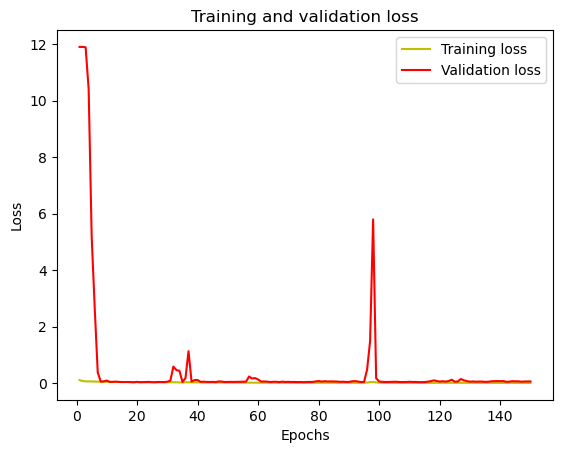

In [20]:
history = att_res_SegNet_history

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

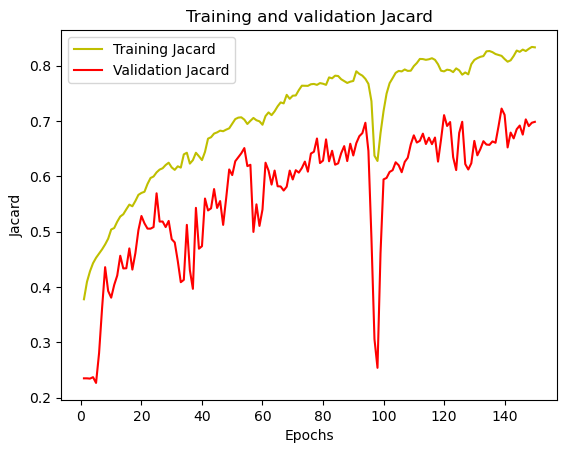

In [21]:
acc = history.history['jacard_coef']
#acc = history.history['accuracy']
val_acc = history.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Jacard')
plt.plot(epochs, val_acc, 'r', label='Validation Jacard')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()

1/1 [==============================] - 2s 2s/step


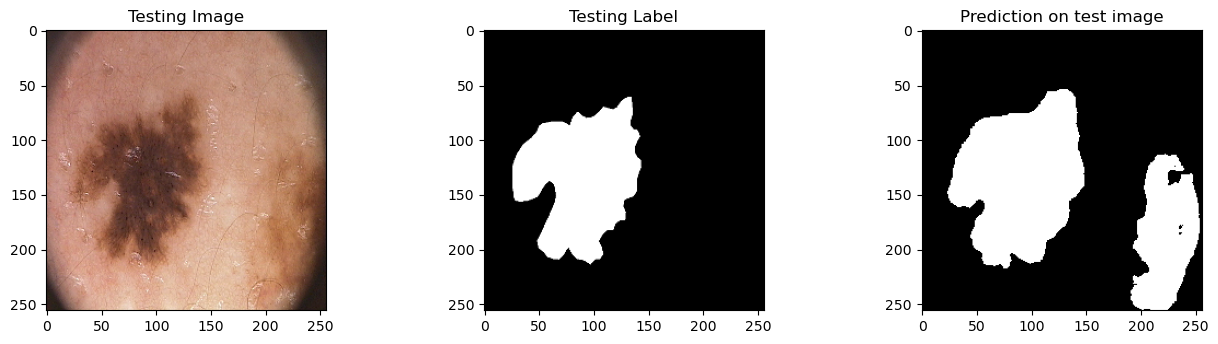

In [22]:
model = att_res_SegNet_model

import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [23]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.70273405


### Interpretability

In [49]:
def visualize_conv_layer(int_out, row_size, col_size):
   
  img_index=0

  print(np.shape(int_out))
  
  fig,ax=plt.subplots(row_size,col_size, figsize=(20, 5))
  for row in range(0,row_size):
    for col in range(0,col_size):
      ax[row][col].imshow(int_out[0, :, :, img_index], cmap='jet')
      ax[row][col].axis('off')
      img_index=img_index+1
        
print("Function to Visualize the Output has been Created")

Function to Visualize the Output has been Created


Attention block 1
1/1 [==============================] - 1s 554ms/step
(1, 16, 16, 512)


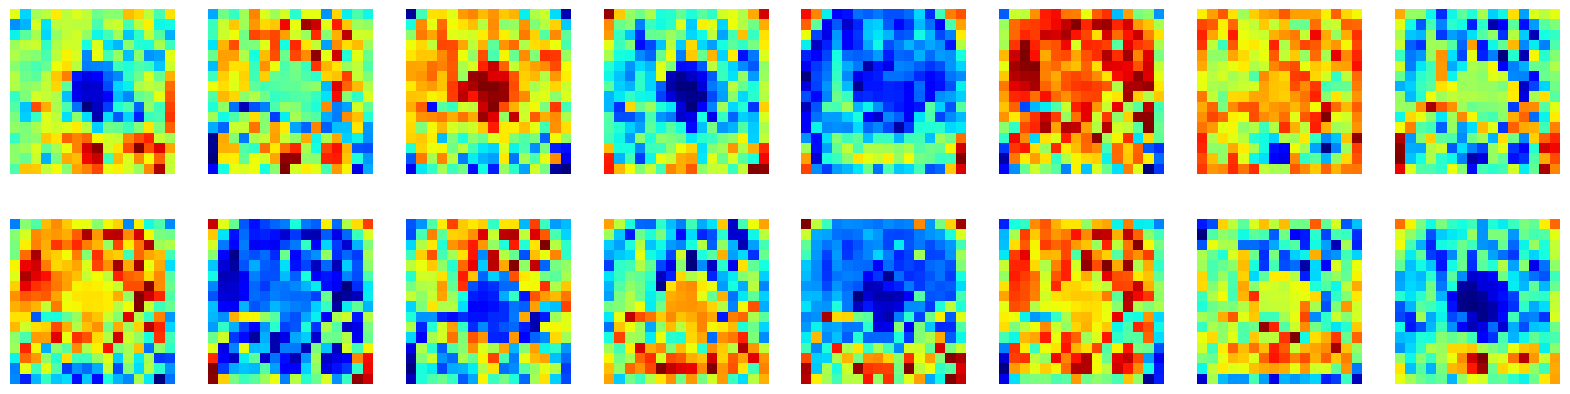

In [50]:
attention_blocks = [att_512_2, att_512_1, att_256, att_128, att_64]
print("Attention block 1")
in_to_intermediate = Model(inputs=input_inter, outputs=attention_blocks[0])
int_out = in_to_intermediate.predict(test_img_input)
visualize_conv_layer(int_out,2,8)

Attention block 2
1/1 [==============================] - 2s 2s/step
(1, 32, 32, 512)


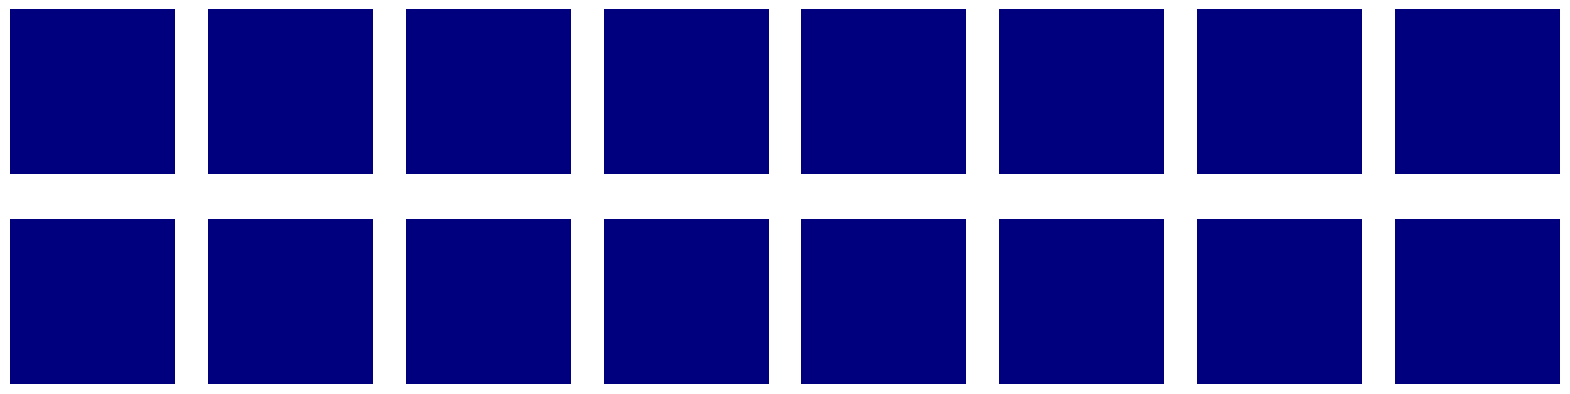

In [51]:
print("Attention block 2")
in_to_intermediate = Model(inputs=input_inter, outputs=attention_blocks[1])
int_out = in_to_intermediate.predict(test_img_input)
visualize_conv_layer(int_out,2 ,8)

Attention block 3
1/1 [==============================] - 1s 1s/step
(1, 64, 64, 256)


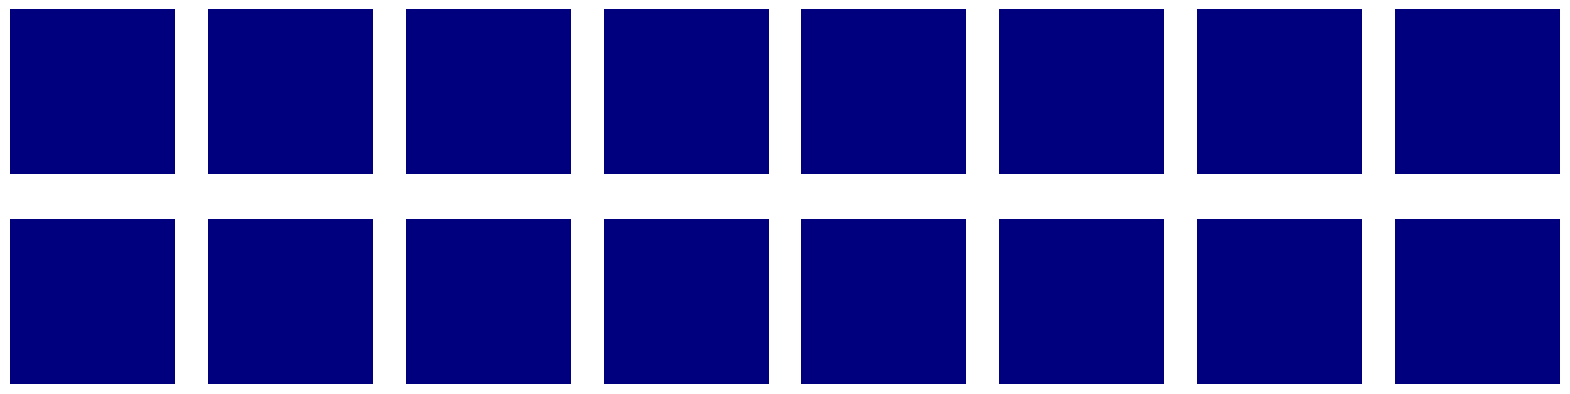

In [52]:
print("Attention block 3")
in_to_intermediate = Model(inputs=input_inter, outputs=attention_blocks[2])
int_out = in_to_intermediate.predict(test_img_input)
visualize_conv_layer(int_out,2,8)

Attention block 4
1/1 [==============================] - 1s 1s/step
(1, 128, 128, 128)


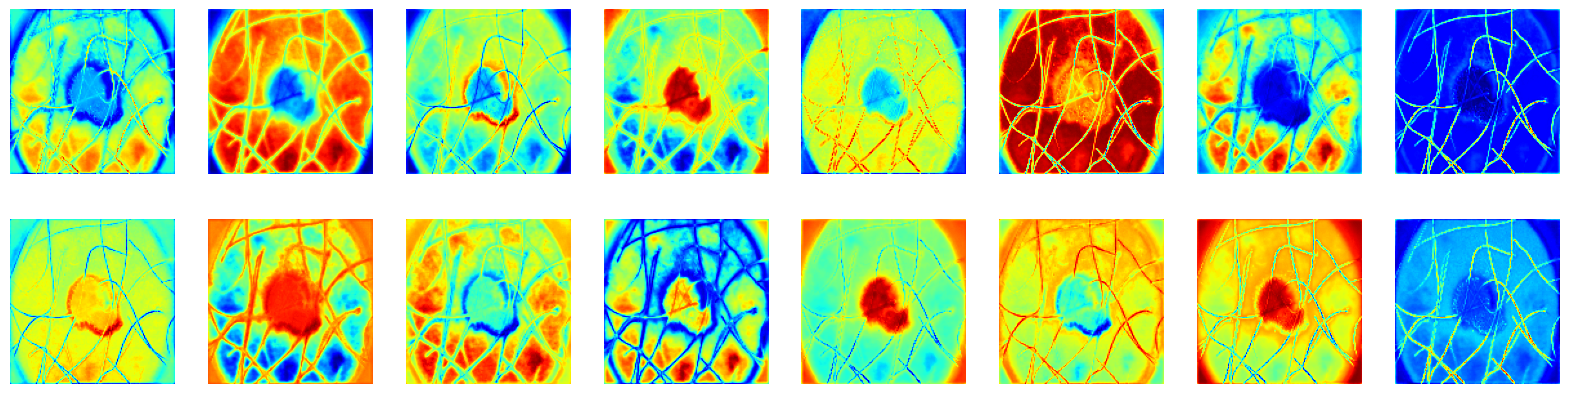

In [53]:
print("Attention block 4")
in_to_intermediate = Model(inputs=input_inter, outputs=attention_blocks[3])
int_out = in_to_intermediate.predict(test_img_input)
visualize_conv_layer(int_out,2,8)

Attention block 5
1/1 [==============================] - 2s 2s/step
(1, 256, 256, 64)


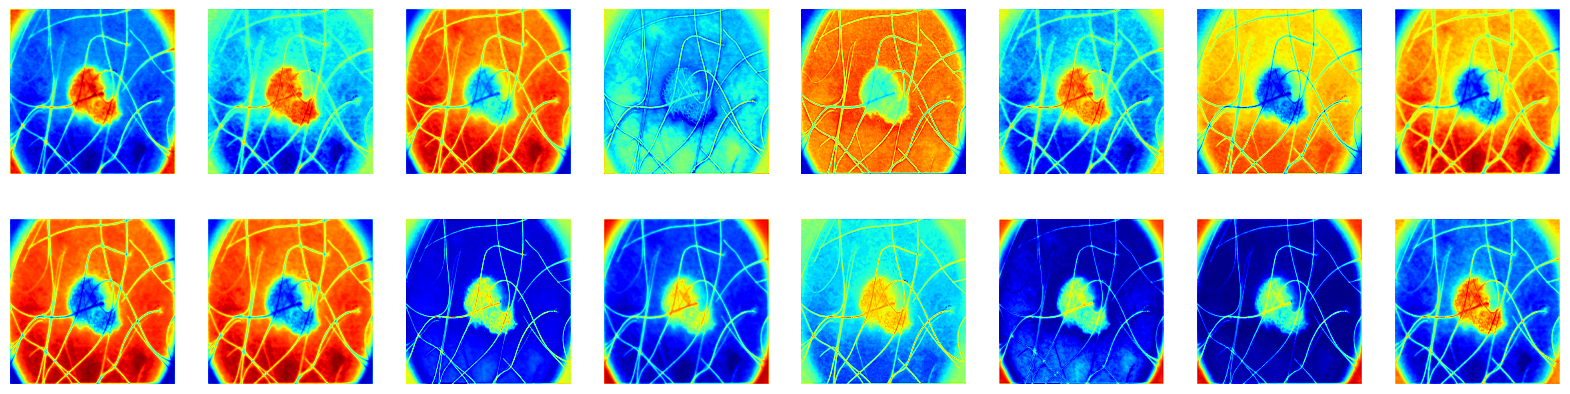

In [54]:
print("Attention block 5")
in_to_intermediate = Model(inputs=input_inter, outputs=attention_blocks[4])
int_out = in_to_intermediate.predict(test_img_input)
visualize_conv_layer(int_out,2,8)